# Plate

In [78]:
from source import utils, model, detector
from source import IamgesTransformations
from source import MatriculasDataset
import scipy
import pandas as pd
import numpy as np
import plotly.graph_objects as go

## Data soruces

### Source 0: Dataset

In [27]:
pth = 'data'
data = detector.get_data('data')

In [28]:
locator = detector.PlateLocator()
dataset, names = locator.get_dataset(data, 56)
X_data = []
y_data = []
n_Test = 10
i = 0
for element,name in zip(dataset[:len(dataset) - n_Test],names):
    name_ = name.split('/')[1].replace('.jpg','')
    for detection in element:
        if len(detection) == 7:    
            for image,letter in zip(detection, name_) :
                if letter == 'P':                   
                    X_data.append(image)
                    y_data.append(letter)
                X_data.append(image)
                y_data.append(letter)


[INFO] Loaded 56 images
[INFO] Located 87 plates
[INFO] Segmented 633 characters


In [29]:
X_data = np.array(X_data)
y_data = np.array(y_data)

### Source 1: Curated dataset

In [30]:
from torch.utils.data import DataLoader

In [31]:
MD = MatriculasDataset.DatasetAugmentated('curated_data/', 1000)

In [32]:
tmp = DataLoader(MD, batch_size = 200)
X_data_curated = np.zeros((1000, 60, 30))
y_data_curated = np.zeros(1000)
i = 0
for batch, target in tmp:
    for image, letter in zip(batch, target):
        X_data_curated[i] = image[0]
        y_data_curated[i] = letter.item()
        i+=1
        
gt_mapper = MD.char_to_indx
gt_mapper = {gt_mapper[x] : x for x in gt_mapper}

In [204]:
def boxplots(model, n_params = 10, duplicates = False): #for top_params_df
    df = model.top_params(0.95, n_params)
    df = df.filter(regex = 'test')
    if not duplicates:
        df = df.drop_duplicates()
    df = df.T
    fig = go.Figure()
    for n in range(df.shape[1]):
        fig.add_trace(go.Box(y = df[list(df.columns)[n]],  boxpoints='all', name = f'Params {n}'))
        
    fig.update_layout(
    title = f"NSplits Boxplots {str(model.model.__class__).split('.')[-1][:-2]}",
    xaxis_title = 'Acc',
    )
    
    fig.show()

# Plate Locator example

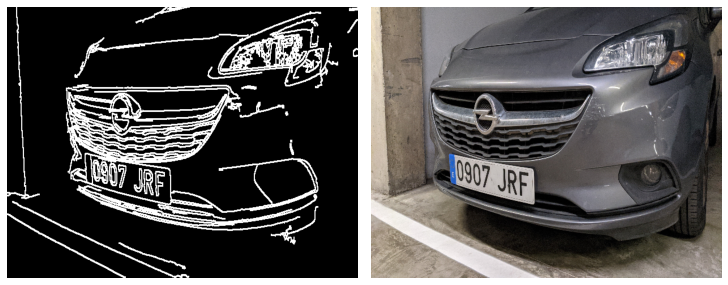

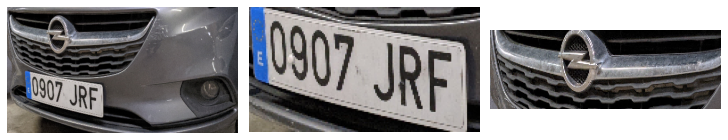

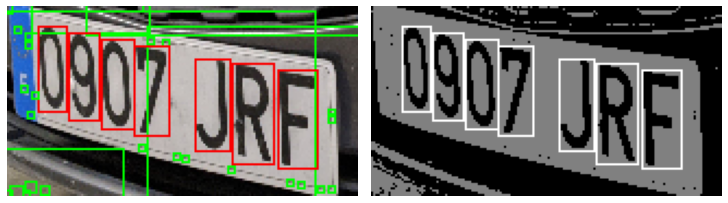

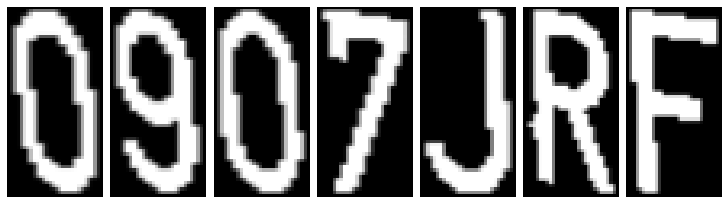

In [227]:
proc = detector.PlateLocator().process(data[5], True)
numb = detector.PlateLocator().numbers(proc[1], True)

# Models

## SVM

### Training with Data

In [165]:
svm_d = model.ModelHandler(X = X_data, Y = y_data, model = 'SVM', n_splits = 5)
svm_d.fit(True,True)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 tasks      | elapsed:    5.8s
[Parallel(n_jobs=6)]: Done 100 out of 100 | elapsed:   16.0s finished


[INFO] The best parameters are {'C': 10.0, 'kernel': 'sigmoid'}
[INFO] The best score is 0.9753
[INFO] The best parameters according to ci are {'C': 10000000000.0, 'kernel': 'sigmoid'}
[INFO] Train acc  is : 1.0000


In [228]:
boxplots(svm_d, 10)

### Training with Augmented Data

In [40]:
svm_c = model.ModelHandler(X = X_data_curated, Y = y_data_curated, model = 'SVM', n_splits = 5)
svm_c.fit(True,True)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 tasks      | elapsed:   19.3s
[Parallel(n_jobs=6)]: Done 100 out of 100 | elapsed:  1.0min finished


[INFO] The best parameters are {'C': 0.01, 'kernel': 'linear'}
[INFO] The best score is 0.9730
[INFO] The best parameters according to ci are {'C': 0.01, 'kernel': 'linear'}
[INFO] Train acc  is : 0.9960


In [211]:
boxplots(svm_c, 10)

#### Acc on dataset

In [51]:
pred = list(map(lambda x: gt_mapper[int(x)], svm_c.predict(X_data)))
svm_c._acc(pred, y_data)

0.9800498753117207

## KNN

### Training with Data

In [43]:
knn_d = model.ModelHandler(X = X_data, Y = y_data, model = 'KNN', n_splits = 5)
knn_d.fit(True,True)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 tasks      | elapsed:    1.1s
[Parallel(n_jobs=6)]: Done 116 tasks      | elapsed:    4.9s
[Parallel(n_jobs=6)]: Done 160 out of 160 | elapsed:    5.5s finished


[INFO] The best parameters are {'algorithm': 'auto', 'n_neighbors': 3, 'p': 1}
[INFO] The best score is 0.9432
[INFO] The best parameters according to ci are {'algorithm': 'auto', 'n_neighbors': 3, 'p': 1}
[INFO] Train acc  is : 0.9726


In [213]:
boxplots(knn_d, 10)

### Training with Augmented Data

In [44]:
knn_c = model.ModelHandler(X = X_data_curated, Y = y_data_curated, model = 'KNN', n_splits = 5)
knn_c.fit(True,True)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 tasks      | elapsed:    5.3s
[Parallel(n_jobs=6)]: Done 116 tasks      | elapsed:   25.9s
[Parallel(n_jobs=6)]: Done 160 out of 160 | elapsed:   28.8s finished


[INFO] The best parameters are {'algorithm': 'auto', 'n_neighbors': 3, 'p': 1}
[INFO] The best score is 0.9210
[INFO] The best parameters according to ci are {'algorithm': 'auto', 'n_neighbors': 3, 'p': 1}
[INFO] Train acc  is : 0.9850


In [214]:
boxplots(knn_c, 10)

#### Acc on dataset

In [52]:
pred = list(map(lambda x: gt_mapper[int(x)], knn_c.predict(X_data)))
knn_c._acc(pred, y_data)

0.9750623441396509

## DTC

### Training with Data

In [53]:
dt_d = model.ModelHandler(X = X_data, Y = y_data, model = 'DT', n_splits = 5)
dt_d.fit(True,True)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  28 out of  60 | elapsed:    0.1s remaining:    0.2s


[INFO] The best parameters are {'criterion': 'entropy', 'max_features': 'auto', 'splitter': 'random'}
[INFO] The best score is 0.8889
[INFO] The best parameters according to ci are {'criterion': 'entropy', 'max_features': 'auto', 'splitter': 'random'}
[INFO] Train acc  is : 1.0000


[Parallel(n_jobs=6)]: Done  60 out of  60 | elapsed:    0.2s finished


In [216]:
boxplots(dt_d, 5)

### Training with Augmented Data

In [54]:
dt_c = model.ModelHandler(X = X_data_curated, Y = y_data_curated, model = 'DT', n_splits = 5)
dt_c.fit(True,True)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  28 out of  60 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=6)]: Done  60 out of  60 | elapsed:    0.4s finished


[INFO] The best parameters are {'criterion': 'entropy', 'max_features': 'auto', 'splitter': 'best'}
[INFO] The best score is 0.9240
[INFO] The best parameters according to ci are {'criterion': 'gini', 'max_features': 'sqrt', 'splitter': 'best'}
[INFO] Train acc  is : 0.9960


In [218]:
boxplots(dt_c, 5)

#### Acc on dataset

In [55]:
pred = list(map(lambda x: gt_mapper[int(x)], dt_c.predict(X_data)))
dt_c._acc(pred, y_data)

0.7955112219451371

## DL

In [8]:
from source import binary_classifier 
import torch

In [6]:
DL_w = binary_classifier.get_model('trained_models/model.pth')

tmp = DataLoader(MD, batch_size = 200)
X_data_curated = np.zeros((5, 1000, 1, 60, 30))
y_data_curated = np.zeros((5, 1000))
for n in range(5):
    i = 0
    for batch, target in tmp:
        for image, letter in zip(batch, target):
            X_data_curated[n,i] = image
            y_data_curated[n,i] = letter.item()
            i+=1
        
gt_mapper = MD.char_to_indx
gt_mapper = {gt_mapper[x] : x for x in gt_mapper}

In [ ]:
idx_to_letters = {x: y for x, y in enumerate(
    '2S1NEK8W06BJ47FYV5QUXDOGAL9 T3RCMIPHZ')}

In [19]:
for n in range(5):
    out = DL_w(torch.from_numpy(X_data_curated[n]).float())
    #print(model.ModelHandler._acc('s',torch.argmax(out,1), y_data_curated[n]))
    #print(torch.argmax(out,1))
    #s'han de mappejar resultats

tensor([ 0,  8, 35,  4,  2, 14, 13, 36, 23, 10, 27, 17, 26, 24, 16, 11, 11, 15,
        21, 33, 20, 13, 29,  5,  3,  9,  1, 19, 12, 34,  7,  6, 30, 22, 18, 27,
        35, 20,  5, 10,  0, 33,  2, 25,  0,  9, 18, 10, 27, 23,  3, 29, 33, 31,
        15, 12, 24,  7, 26,  8, 14, 34,  6, 21,  1,  4, 19, 16, 11, 17, 20, 13,
         2, 19,  0, 30, 12,  6, 31, 23, 33, 27, 31, 34, 22,  7, 35,  3, 17, 18,
        11,  4,  1, 29, 10, 15, 21,  9, 24, 16, 25, 26, 22, 14, 26, 18,  8, 15,
        17, 30,  2, 26,  3, 35, 14,  7,  0, 20, 27,  6, 13, 36, 22, 17,  5, 19,
        24, 16, 31, 31, 21,  4, 11, 12, 33, 29,  9, 10, 23, 25, 13, 33,  9, 25,
        35, 18, 30, 20, 11,  1, 17,  2, 21, 26, 11,  0, 15, 23, 14,  8, 27, 36,
        19,  6, 34, 16, 22, 35,  4, 24, 18, 31,  5, 16,  7, 34,  1, 23, 15, 27,
        13, 26,  4, 16, 30,  6, 36,  8, 36, 18, 25,  0, 22, 33, 19, 14,  5, 21,
        10, 20, 17, 24,  7, 11,  2,  9, 31, 33,  3, 11, 18, 14,  0, 35, 16, 12,
        11, 26,  8, 15, 27, 17, 35,  9, 

tensor([35, 20, 33,  5, 21, 31,  9,  3,  2, 12, 29, 34,  6, 15,  7, 18, 13, 26,
        31, 36, 22,  4, 14, 11,  1, 23,  7, 19, 17, 24, 10, 25, 27, 16, 30,  9,
        16, 24, 33, 17, 27,  6, 20, 26, 36,  7,  1,  8, 29, 30, 13,  0, 15, 19,
        35,  4,  6, 10,  5, 18, 25, 21, 31, 23, 33, 14,  7, 12, 34, 22, 14, 25,
        29, 18, 22, 26, 16, 20, 17,  2, 10, 35,  3, 11,  6, 30,  5,  8, 24, 27,
        34, 15, 13, 36,  9,  0, 33, 12,  1,  2, 19,  7, 21, 22, 31,  9,  7, 18,
         4, 19, 36, 22,  0, 20, 15, 12, 17, 26, 29, 22,  8, 31,  3, 16, 27, 35,
        35, 24, 10,  1, 23,  9, 14, 34, 30,  2, 25, 33, 13,  6, 10, 20, 30, 27,
         6, 15,  5, 16, 17,  7, 14,  8,  4, 21,  6, 13,  0, 18, 26,  9, 31, 25,
        24, 33,  1,  6, 36, 22, 29, 34,  2, 19, 35, 11, 12, 30, 33,  9, 16, 31,
        35, 18,  3,  2, 14,  8,  0, 35, 21, 25, 17,  1, 24, 23, 11, 25,  7, 22,
        26,  4, 19, 34, 29,  5,  6, 20, 36, 15, 12, 13, 12, 36,  6, 16, 18,  3,
         8,  1,  5, 29, 11, 19,  0, 15, 

tensor([24,  5, 33, 35,  2, 21, 15, 17, 20, 19, 16, 23,  4, 18,  7, 30, 27, 12,
         0, 14, 11, 33, 34,  9, 13,  8, 10, 25,  6, 31, 34, 11, 36,  3, 26, 17,
        25, 15,  7, 21, 27, 29,  2,  6,  1, 35, 16,  3, 22, 30,  7, 23, 33,  9,
        14,  4, 20, 11, 19, 34, 12, 10,  0, 36, 24, 18, 13, 31,  8, 31, 22,  7,
         0, 24, 10, 17, 26, 11,  2,  2, 16, 19, 14,  1, 36,  9, 35, 27,  8, 12,
        33, 21, 15, 30, 23, 13,  3,  7, 25, 34,  6,  4, 29, 31, 20, 13, 17, 23,
         3, 20, 20, 15, 26, 31, 27, 16, 14, 22,  0, 25, 10, 19,  8,  0, 18, 21,
        34, 15, 35,  7, 30,  4,  9, 12,  6,  1, 33,  5, 36, 11, 23, 15, 10,  1,
         0, 27,  8, 34, 19, 11, 30, 16, 21, 18, 20, 14, 36, 22, 31, 24, 26, 25,
         5, 33,  4,  7,  6, 35,  3, 23, 12,  2, 13,  9, 29,  6, 23, 26, 10,  7,
         4, 35,  5, 25,  1, 31, 19, 13, 34, 18, 12, 17, 20, 24, 13, 16, 30,  7,
         9, 15, 27, 22,  8, 33, 36,  2, 11, 13,  3, 21, 12, 16,  2, 15, 23, 14,
        26, 36, 24, 30, 22, 17, 19, 27, 

## ANOVA

H₀: μ₁= μ₂ = μ₃ = … = μ4

H₁: Not all model means are equal

α = 0.05

In [219]:
s = list(svm_c.top_params(0.95, 1).filter(regex = 'test').iloc[0,:])
k = list(knn_c.top_params(0.95, 1).filter(regex = 'test').iloc[0,:])
d = list(dt_c.top_params(0.95, 1).filter(regex = 'test').iloc[0,:])

In [221]:
f, p = scipy.stats.f_oneway(k ,s, d)

In [225]:
f'p value {p}'

'p value 1.2437353324003406e-05'

p < 0.05 així que es rebutja H0 i s'accepta H1: no tots els mètodes són iguals